In [1]:
import pypsa
import yaml
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import seaborn as sns

import sys
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.patches import Circle, Patch
from matplotlib.legend_handler import HandlerPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import cartopy.crs as ccrs
import cartopy

import multiprocessing as mp
from itertools import product


from pypsa.plot import projected_area_factor
from pypsa.descriptors import get_switchable_as_dense as as_dense

PATH = "../subworkflows"
SCRIPTS_PATH = "pypsa-eur/scripts/"

sys.path.append(os.path.join(PATH, SCRIPTS_PATH))
from plot_summary import rename_techs
from plot_network import make_legend_circles_for, assign_location
from helper import override_component_attrs

#import holoviews as hv
#from holoviews import opts, dim

#hv.extension("bokeh")
#hv.output(size=200)

plt.style.use(["bmh", "matplotlibrc"])
xr.set_options(display_style="html")

%matplotlib inline

ModuleNotFoundError: No module named 'plot_summary'

In [ ]:
CLUSTERS = 128
LL = "2.0"
OPTS = "Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext15"
RUN = "v8"
SCENARIO = f"elec_s_{CLUSTERS}_lv{LL}__{OPTS}_2030"
OVERRIDES = PATH + "pypsa-eur-sec/data/override_component_attrs"

OUTPUT = "../results/"
OUTPUT_SCENARIO = f"{OUTPUT}/{RUN}/{SCENARIO}/"

IMPORT_REGIONS = ['CN-West', 'DZ', 'EG', 'KZ', 'LY', 'MA', 'SA', 'TN', 'TR', 'UA']

In [18]:
if not os.path.exists(OUTPUT_SCENARIO):
    os.makedirs(OUTPUT_SCENARIO)

In [19]:
with open("../../config/config.pypsaeursec.yaml") as file:
    config = yaml.safe_load(file)

In [20]:
tech_colors = config["plotting"]["tech_colors"]

In [21]:
fn = f"{PATH}/pypsa-eur/resources/regions_onshore_elec_s_{CLUSTERS}.geojson"
nodes = gpd.read_file(fn).set_index("name")

fn = f"{PATH}/pypsa-eur/resources/regions_offshore_elec_s_{CLUSTERS}.geojson"
offnodes = gpd.read_file(fn).set_index("name")

fn = f"{PATH}/pypsa-eur/resources/country_shapes.geojson"
cts = gpd.read_file(fn).set_index("name")

regions = pd.concat(
    [
        gpd.read_file(f"{PATH}/pypsa-eur/resources/regions_onshore.geojson"),
        gpd.read_file(f"{PATH}/pypsa-eur/resources/regions_offshore.geojson"),
    ]
)
regions = regions.dissolve("name")

fn = f"{PATH}/pypsa-eur/resources/regions_onshore.geojson"
onregions = gpd.read_file(fn).set_index("name")

fn = f"{PATH}/pypsa-eur/resources/regions_onshore.geojson"
offregions = gpd.read_file(fn).set_index("name")

epsg = 3035
regions["Area"] = regions.to_crs(epsg=epsg).area.div(1e6)
onregions["Area"] = onregions.to_crs(epsg=epsg).area.div(1e6)
offregions["Area"] = offregions.to_crs(epsg=epsg).area.div(1e6)
nodes["Area"] = nodes.to_crs(epsg=epsg).area.div(1e6)

In [22]:
europe_shape = nodes.dissolve()
europe_shape.index = ["EU"]

In [23]:
minx, miny, maxx, maxy = europe_shape.explode(ignore_index=True).total_bounds
BOUNDARIES = [minx, maxx - 4, miny, maxy]

In [24]:
overrides = override_component_attrs(OVERRIDES)
fn = f"{PATH}/pypsa-eur-sec/results/{RUN}/postnetworks/{SCENARIO}.nc"
n = pypsa.Network(fn, override_component_attrs=overrides)

INFO:pypsa.io:Imported network elec_s_128_lv2.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext15_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [25]:
unique_link_carriers = n.links.carrier.unique()
GAS_NETWORK = "gas pipeline" in unique_link_carriers
H2_NETWORK = any("H2 pipeline" in ulc for ulc in unique_link_carriers)

## Utilities

In [438]:
class HandlerCircle(HandlerPatch):
    """
    Legend Handler used to create circles for legend entries.

    This handler resizes the circles in order to match the same dimensional
    scaling as in the applied axis.
    """

    def create_artists(
        self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans
    ):
        fig = legend.get_figure()
        ax = legend.axes

        unit = np.diff(ax.transData.transform([(0, 0), (1, 1)]), axis=0)[0][1]
        radius = orig_handle.get_radius() * unit * (72 / fig.dpi)
        center = 5 - xdescent, 3 - ydescent
        p = plt.Circle(center, radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]


def add_legend_circles(
    ax, sizes, labels, scale=1, srid=None, patch_kw={}, legend_kw={}
):

    if srid is not None:
        area_correction = projected_area_factor(ax, n.srid) ** 2
        sizes = [s * area_correction for s in sizes]

    handles = make_legend_circles_for(sizes, scale, **patch_kw)

    legend = ax.legend(
        handles, labels, handler_map={Circle: HandlerCircle()}, **legend_kw
    )

    ax.add_artist(legend)


def add_legend_lines(ax, sizes, labels, scale=1, patch_kw={}, legend_kw={}):

    handles = [Line2D([0], [0], linewidth=s / scale, **patch_kw) for s in sizes]

    legend = ax.legend(handles, labels, **legend_kw)

    ax.add_artist(legend)


def add_legend_patch(ax, colors, labels, patch_kw={}, legend_kw={}):

    handles = [Patch(facecolor=c, **patch_kw) for c in colors]

    legend = ax.legend(handles, labels, **legend_kw)

    ax.add_artist(legend)

## Import Options

In [439]:
m = n.copy()

In [440]:
inputs = pd.read_csv(f"{PATH}/pypsa-eur-sec/resources/gas_input_locations_s_128_simplified.csv", index_col=0)[["lng", "pipeline"]]

In [441]:
inputs.loc[inputs.index.str.contains("DE") | inputs.index.str.contains('GB') | inputs.index.str.contains('BE') | inputs.index.str.contains("FR"), "pipeline"] = 0.

In [442]:
inputs = inputs.stack()

In [443]:
tech_colors["lng"] = 'coral'
tech_colors["pipeline"] = 'orchid'

In [444]:
assign_location(m)

In [445]:
m.generators["e"] = (m.snapshot_weightings.generators @ m.generators_t.p).div(1e6)

In [446]:
m.stores["e"] = (m.stores_t.e.iloc[0] - m.stores_t.e.iloc[-1]).div(1e6)

In [447]:
imp_gen = m.generators.loc[m.generators.carrier.str.contains("external")].groupby(['bus', 'carrier']).e.sum()

In [448]:
imp = m.generators.filter(regex='import (pipeline-h2|shipping-lh2)', axis=0)

In [449]:
imp = imp.groupby([imp.bus.map(m.buses.location), imp.carrier]).e.sum()

In [450]:
imp_sto = m.stores.filter(regex='import shipping-lch4', axis=0)

In [451]:
imp_sto_buses = imp_sto.bus.str.split(" ").str[:2].map(lambda x: " ".join(x))

In [452]:
imp_sto = imp_sto.groupby([imp_sto_buses, imp_sto.carrier]).e.sum()

In [453]:
bus_sizes = pd.concat([imp_gen, imp, imp_sto], axis=0).div(2e2)

In [414]:
h2_cost = m.generators.filter(regex="import (pipeline-h2|shipping-lh2)", axis=0)

In [415]:
nodes["marginal_cost"] = h2_cost.groupby(h2_cost.bus.map(m.buses.location)).marginal_cost.min()

In [416]:
m.buses.drop(m.buses.index[m.buses.carrier != "AC"], inplace=True)

In [417]:
m.buses.loc["KZ", "x"] = 52

In [418]:
m.buses.loc["KZ", "y"] = 49

In [419]:
m.buses.loc["CN-West", "x"] = 79

In [420]:
m.buses.loc["CN-West", "y"] = 38

In [421]:
link_colors = pd.Series(m.links.index.map(lambda x: "olivedrab" if "import hvdc-to-elec" in x else "firebrick"), index=m.links.index)

In [422]:
mi = pd.MultiIndex.from_product([IMPORT_REGIONS, ['external solar-utility', 'external onwind', 'external offwind', "external battery", "external H2"]])
bus_sizes_plain = pd.concat([pd.Series(.1, index=mi), inputs.div(4e5)], axis=0)

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:82

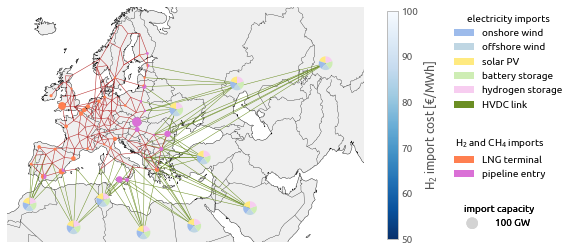

In [383]:
proj = ccrs.Orthographic(10,50)
#proj = ccrs.EqualEarth()
fig, ax = plt.subplots(subplot_kw={"projection": proj}, figsize=(8,12))

nodes = nodes.to_crs(proj.proj4_init)

m.plot(
    ax=ax,
    color_geomap={'ocean': 'white', 'land': '#efefef'},
    bus_sizes=bus_sizes_plain,
    bus_colors=tech_colors,
    line_colors='firebrick',
    line_widths=.5,
    link_widths=.5,
    link_colors=link_colors,
    boundaries=[-11,80,23,54],
)

nodes.plot(
    ax=ax,
    column="marginal_cost",
    cmap='Blues_r',
    linewidths=0,
    vmin=50,
    vmax=100,
    legend=True,
    legend_kwds={
        "label": r"H$_2$ import cost [€/MWh]",
        "shrink": 0.35,
    },
)

names = {
    "external onwind": "onshore wind",
    "external offwind": "offshore wind",
    "external solar-utility": "solar PV",
    "external battery": "battery storage",
    "external H2": "hydrogen storage",
}
labels = list(names.values()) + ["HVDC link"]
colors = [tech_colors[c] for c in names.keys()] + ['olivedrab']

legend_kw = dict(
    bbox_to_anchor=(1.58, 1.01),
    frameon=False,
    title="electricity imports"
)

add_legend_patch(
    ax,
    colors,
    labels,
    legend_kw=legend_kw,
)

legend_kw = dict(
    bbox_to_anchor=(1.5325, 0.49),
    frameon=False,
    title="H$_2$ and CH$_4$ imports"
)

names = {
    "lng": "LNG terminal",
    "pipeline": "pipeline entry",
}
labels = names.values()
colors = [tech_colors[c] for c in names.keys()]

add_legend_patch(
    ax,
    colors,
    labels,
    legend_kw=legend_kw,
)

legend_kw = dict(
    bbox_to_anchor=(1.5, 0.2),
    frameon=False,
    title='import capacity',
)

add_legend_circles(
    ax,
    [100/400/0.7], # somehow can't get projection to work
    ["100 GW"],
    srid=m.srid,
    patch_kw=dict(facecolor="lightgrey"),
    legend_kw=legend_kw
)

plt.savefig(
    f"{OUTPUT_SCENARIO}/import-option-step.pdf",
    bbox_inches="tight"
)

In [423]:
ptx = m.links.filter(regex="(Fischer|Sabatier|Electrolysis)", axis=0)

In [424]:
ptx["cost"] = ptx.eval("p_nom_opt * capital_cost / 1e6")

/tmp/ipykernel_117332/1996817911.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [425]:
ptx = ptx.groupby(ptx.bus0.map(m.buses.location)).cost.sum()
ptx = ptx.loc[ptx > 1]

In [426]:
nodes["ptx"] = ptx

In [306]:
eu_sizes = pd.Series({
    ('EU', 'import shipping-lnh3'): (m.snapshot_weightings.generators @ m.generators_t.p.filter(like='import shipping-lnh3').div(1e6)).values[0],
    ('EU', 'import shipping-ftfuel'): (m.snapshot_weightings.generators @ m.links_t.p0.filter(like='import shipping-ftfuel').div(1e6)).values[0],
}).div(2e2)
eu_sizes.index.names = ['bus', 'carrier']

In [307]:
if "EU" in m.buses.index: m.remove("Bus", "EU")
m.add("Bus", "EU", x=-15, y=58)

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:82

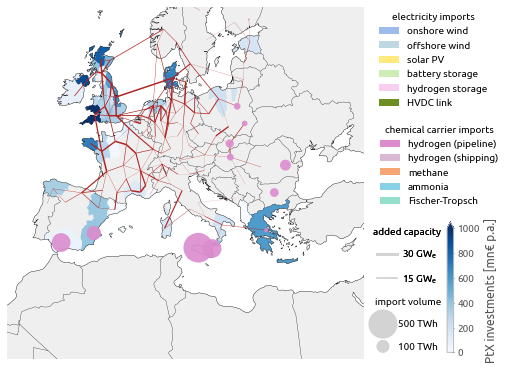

In [427]:
proj = ccrs.Orthographic(10,50)

lw = m.links.p_nom_opt
lw = lw.where(lw > 1000).fillna(0.).div(1e4)

line_widths = n.lines.eval("s_nom_opt - s_nom")
line_widths = line_widths.where(line_widths > 1000).fillna(0.).div(1e4)

fig, ax = plt.subplots(subplot_kw={"projection": proj}, figsize=(8,12))
m.plot(
    ax=ax,
    color_geomap={'ocean': 'white', 'land': '#efefef'},
    bus_sizes=bus_sizes,
    bus_colors=tech_colors,
    line_colors='firebrick',
    line_widths=line_widths,
    link_widths=lw,
    link_colors=link_colors,
    boundaries=[-9.5,32.5,23,62],
    bus_alpha=0.9,
)

if "EU" in n.buses.index:
    m.plot(
        ax=ax,
        geomap=True,
        bus_sizes=eu_sizes,
        branch_components=[],
        boundaries=[-9.5,32.5,23,62],
       bus_colors=tech_colors,
    )

nodes = nodes.to_crs(proj.proj4_init)

nodes.plot(
    ax=ax,
    column="ptx",
    cmap='Blues',
    linewidths=0,
    vmin=0,
    vmax=1000,
    legend=True,
    legend_kwds={
        "label": r"PtX investments [mn€ p.a.]",
        "shrink": 0.2,
        "extend": 'max',
        "location": 'right',
        "anchor": (1.0, 0.3)
    },
)

names = {
    "external onwind": "onshore wind",
    "external offwind": "offshore wind",
    "external solar-utility": "solar PV",
    "external battery": "battery storage",
    "external H2": "hydrogen storage",
}
labels = list(names.values()) + ["HVDC link"]
colors = [tech_colors[c] for c in names.keys()] + ['olivedrab']

legend_kw = dict(
    bbox_to_anchor=(1.37, 1.01),
    frameon=False,
    title="electricity imports"
)

add_legend_patch(
    ax,
    colors,
    labels,
    legend_kw=legend_kw,
)


names = {
    "import pipeline-h2": 'hydrogen (pipeline)',
    "import shipping-lh2": 'hydrogen (shipping)',
    "import shipping-lch4": 'methane',
    "import shipping-lnh3": 'ammonia',
    "import shipping-ftfuel": 'Fischer-Tropsch'
}
labels = names.values()
colors = [tech_colors[c] for c in names.keys()]

legend_kw = dict(
    bbox_to_anchor=(1.4, .69),
    frameon=False,
    title="chemical carrier imports"
)

add_legend_patch(
    ax,
    colors,
    labels,
    legend_kw=legend_kw,
)

legend_kw = dict(
    bbox_to_anchor=(1.24, 0.2),
    frameon=False,
    labelspacing=1.3,
    handletextpad=0,
    title='import volume',
)

add_legend_circles(
    ax,
    [500/200/0.7, 100/200/0.7], # somehow can't get projection to work
    ["500 TWh", "100 TWh"],
    srid=m.srid,
    patch_kw=dict(facecolor="lightgrey"),
    legend_kw=legend_kw
)

sizes = [30, 15]
labels = [f"{s}" + r" GW$_e$" for s in sizes]

legend_kw = dict(
    bbox_to_anchor=(1.24, 0.4),
    frameon=False,
    labelspacing=1.2,
    handletextpad=0.5,
    title="added capacity"
)

add_legend_lines(
    ax,
    sizes,
    labels,
    scale=1e4/1e3,
    patch_kw=dict(color='lightgrey'),
    legend_kw=legend_kw
)

plt.savefig(
    f"{OUTPUT_SCENARIO}/import-result.pdf",
    bbox_inches="tight"
)

## Balances

In [72]:
def nodal_balance(n, carrier, time=slice(None), aggregate=None, energy=True):

    if not isinstance(carrier, list):
        carrier = [carrier]

    one_port_data = {}

    for c in n.iterate_components(n.one_port_components):

        df = c.df[c.df.bus.map(n.buses.carrier).isin(carrier)]

        if df.empty:
            continue

        s = c.pnl.p.loc[time, df.index] * df.sign

        s = s.groupby([df.bus.map(n.buses.location), df.carrier], axis=1).sum()

        one_port_data[c.list_name] = s

    branch_data = {}

    for c in n.iterate_components(n.branch_components):
        for col in c.df.columns[c.df.columns.str.startswith("bus")]:

            end = col[3:]

            df = c.df[c.df[col].map(n.buses.carrier).isin(carrier)]

            if df.empty:
                continue

            s = -c.pnl[f"p{end}"].loc[time, df.index]

            s = s.groupby([df[col].map(n.buses.location), df.carrier], axis=1).sum()

            branch_data[(c.list_name, end)] = s

    branch_balance = pd.concat(branch_data).groupby(level=[0, 2]).sum()
    one_port_balance = pd.concat(one_port_data)

    def skip_tiny(df, threshold=1e-1):
        return df.where(df.abs() > threshold)

    branch_balance = skip_tiny(branch_balance)
    one_port_balance = skip_tiny(one_port_balance)

    balance = pd.concat([one_port_balance, branch_balance]).stack(level=[0, 1])

    balance.index.set_names(["component", "bus"], level=[0, 2], inplace=True)

    if energy:
        balance = balance * n.snapshot_weightings.generators

    if aggregate is not None:
        keep_levels = balance.index.names.difference(aggregate)
        balance = balance.groupby(level=keep_levels).sum()

    return balance

In [73]:
def get_import_export_gas():

    io = pd.DataFrame()

    fn = f"{PATH}/pypsa-eur-sec/resources/industrial_energy_demand_elec_s_128_2030.csv"
    industrial_demand = pd.read_csv(fn, index_col=0)

    fn = f"{PATH}/pypsa-eur-sec/resources/biomass_potentials_s_128.csv"
    biogas_potentials = pd.read_csv(fn, index_col=0)["biogas"].div(1e6)  # TWh

    e = n.stores_t.e.loc[:, "EU biogas"]
    biogas_used = (e[0] - e[-1]) / e[0]

    biogas_generation = biogas_potentials * biogas_used

    gas_cc_consumption = n.snapshot_weightings.generators @ (
        n.links_t.p0.loc[:, "gas for industry CC"]
        + n.links_t.p1.loc[:, "gas for industry CC"]
    ).div(1e6)

    gas_consumption = n.snapshot_weightings.generators @ n.links_t.p0.filter(
        regex="(OCGT|gas (boiler|CHP)|SMR)", axis=1
    )
    grouper = gas_consumption.index.map(n.links.bus1.map(n.buses.location))
    io["demand"] = (
        gas_consumption.groupby(grouper).sum().div(1e6) + industrial_demand["methane"]
    )  # TWh

    gas_generation = n.snapshot_weightings.generators @ n.links_t.p1.filter(
        regex="(Sabatier|helmeth)", axis=1
    ).mul(-1)
    grouper = gas_generation.index.map(n.links.bus0.map(n.buses.location))
    io["supply"] = (
        gas_generation.groupby(grouper).sum().div(1e6) + biogas_generation
    )  # TWh, assuming biogas potentials uniformly exhausted

    fossil_gas = n.snapshot_weightings.generators @ n.generators_t.p.loc[
        :, "EU gas"
    ].div(1e6)
    io.at["fossil", "supply"] = fossil_gas

    assert abs(io["supply"].sum() - gas_cc_consumption - io["demand"].sum()) < 1

    return io.fillna(0.0)

In [74]:
def get_import_export_oil():

    io = pd.DataFrame()

    fn = f"{PATH}/pypsa-eur-sec/resources/industrial_energy_demand_elec_s_128_2030.csv"
    industrial_demand = pd.read_csv(fn, index_col=0)

    fn = f"{PATH}/pypsa-eur-sec/resources/pop_layout_elec_s_128.csv"
    pop_layout = pd.read_csv(fn, index_col=0)

    fn = f"{PATH}/pypsa-eur-sec/resources/energy_totals.csv"
    energy_totals = pd.read_csv(fn, index_col=0)
    nodal_energy_totals = energy_totals.loc[pop_layout.ct].fillna(0.0)
    nodal_energy_totals.index = pop_layout.index
    nodal_energy_totals = nodal_energy_totals.multiply(pop_layout.fraction, axis=0)

    oil = [
        "total international aviation",
        "total domestic aviation",
        "total agriculture machinery",
    ]

    io["demand"] = industrial_demand["naphtha"] + nodal_energy_totals[oil].sum(axis=1)

    oil_generation = n.snapshot_weightings.generators @ n.links_t.p1.filter(
        like="Fischer-Tropsch", axis=1
    ).mul(-1)
    grouper = oil_generation.index.map(n.links.bus0.map(n.buses.location))
    io["supply"] = oil_generation.groupby(grouper).sum().div(1e6)  # TWh

    fossil_oil = n.snapshot_weightings.generators @ n.generators_t.p.loc[
        :, "EU oil"
    ].div(1e6)
    io.at["fossil", "supply"] = fossil_oil

    assert abs(io["supply"].sum() - io["demand"].sum()) < 1

    return io.fillna(0.0)

## Gini, Lorenz, Equity

In [75]:
def cumulative_share(n, carrier, sortby="supply/demand", df=None):

    if df is None:

        to_drop = [
            "AC",
            "DC",
            "H2 pipeline",
            "gas pipeline",
            "gas pipeline new",
            "H2 pipeline retrofitted",
        ]

        balance = nodal_balance(n, carrier, aggregate=["snapshot"])

        balance = balance.groupby(["bus", "carrier"]).sum().unstack("carrier")
        balance.drop(balance.columns.intersection(to_drop), axis=1, inplace=True)

        supply = balance.where(balance > 0).sum(axis=1)
        demand = -balance.where(balance < 0).sum(axis=1)

        df = pd.concat({"supply": supply, "demand": demand}, axis=1)

    df = df.div(df.sum()) * 100

    df["sortby"] = df.eval(sortby)

    df.sort_values(by="sortby", inplace=True)

    df.drop("sortby", axis=1, inplace=True)

    lead = pd.DataFrame({"supply": [0], "demand": [0]})

    df = pd.concat([lead, df])

    return df.cumsum()

In [76]:
def plot_lorenz(n, carriers, sortby="supply/demand", dfs={}, fn=None):

    for c in set(carriers).difference(dfs.keys()):
        dfs[c] = None

    fig, ax = plt.subplots(figsize=(3.5, 3.5))

    linspace = np.linspace(0, 100, 100)
    ax.plot(linspace, linspace, c="darkgrey", linestyle=":", linewidth=1)

    nice_names = {
        "AC": "electricity",
        "H2": "hydrogen",
        "gas": "methane",
        "oil": "oil",
    }

    for carrier in carriers:
        df = cumulative_share(n, carrier, sortby, df=dfs[carrier])
        ax.plot(
            df.demand,
            df.supply,
            label=nice_names[carrier],
            color=tech_colors[nice_names[carrier]],
        )

    ax.set_xlabel(f"Cumulative Share of Demand [%]")
    ax.set_ylabel(f"Cumulative Share of Supply [%]")
    ax.set_ylim(-1, 101)
    ax.set_xlim(-1, 101)
    ax.legend()

    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")
        plt.close()

In [77]:
carriers = ["oil", "gas", "H2", "AC"]  # if GAS_NETWORK else ["AC", "H2"]

dfs = {"oil": get_import_export_oil()}
if not GAS_NETWORK:
    dfs["gas"] = get_import_export_gas()

plot_lorenz(
    n,
    carriers=carriers,
    sortby="supply/demand",
    dfs=dfs,
    fn=f"{OUTPUT_SCENARIO}/lorenz.pdf",
)

In [78]:
pd.set_option("display.max_rows", 500)

In [79]:
cumulative_share(n, "oil", df=get_import_export_oil())

,supply,demand
0,0.000000,0.000000
DE1 4,0.000232,4.865440
NL1 0,0.000554,10.385234
DE1 1,0.000787,13.506247
DE1 11,0.000959,15.543226
BE1 2,0.001222,18.348293
GB0 1,0.001736,22.240790
NL1 3,0.001991,24.032161
NL1 2,0.002256,25.494234
DE1 0,0.002447,26.357541


## Nodal price duration curve

In [80]:
def plot_price_duration_curve(n, carrier, fn=None):

    df = n.buses_t.marginal_price.loc[:, n.buses.carrier == carrier]

    df = df.stack()

    to_plot = df.sort_values(ascending=False).reset_index(drop=True)

    to_plot.index = [i / len(df) * 100 for i in to_plot.index]

    fig, ax = plt.subplots(figsize=(4, 2.5))
    to_plot.plot(
        ax=ax,
    )
    plt.xlabel("share of snapshots and nodes [%]")
    plt.ylabel("nodal price [EUR/MWh]")
    plt.axvline(0, linewidth=0.5, linestyle=":", color="grey")
    plt.axvline(100, linewidth=0.5, linestyle=":", color="grey")
    plt.axhline(0, linewidth=0.5, linestyle=":", color="grey")

    if carrier == "H2":
        title = "Hydrogen"
        plt.ylim([-20, 350])
    elif carrier == "AC":
        title = "Electricity"
        plt.ylim([-100, 1000])
    else:
        title = carrier

    plt.title(title, fontsize=12, color="#343434")

    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")
        plt.close()

In [81]:
carriers = [
    "AC",
    "H2",
    "residential rural heat",
    "services rural heat",
    "residential urban decentral heat",
    "services urban decentral heat",
    "urban central heat",
    "low voltage",
]

if GAS_NETWORK:
    carriers.append("gas")

In [82]:
for carrier in carriers:
    plot_price_duration_curve(
        n, carrier, fn=f"{OUTPUT_SCENARIO}/price-duration-{carrier}.pdf"
    )

## Maps: Flow Patterns

In [83]:
def plot_h2_flow(network, min_energy=2e6, fn=None):  # MWh net transported

    crs = ccrs.EqualEarth()

    n = network.copy()

    assign_location(n)

    linewidth_factor = 15e5
    # MW below which not drawn
    line_lower_threshold = 1e2
    link_color = "c"

    # Drop non-electric buses so they don't clutter the plot
    n.buses.drop(n.buses.index[(n.buses.carrier != "AC") | (n.buses.index.isin(IMPORT_REGIONS))], inplace=True)

    n.mremove("Link", n.links[~n.links.carrier.str.contains("H2 pipeline")].index)

    n.links.bus0 = n.links.bus0.str.replace(" H2", "")
    n.links.bus1 = n.links.bus1.str.replace(" H2", "")

    n.links["flow"] = n.snapshot_weightings.generators @ n.links_t.p0

    positive_order = n.links.bus0 < n.links.bus1
    swap_buses = {"bus0": "bus1", "bus1": "bus0"}
    n.links.loc[~positive_order] = n.links.rename(columns=swap_buses)
    n.links.loc[~positive_order, "flow"] = -n.links.loc[~positive_order, "flow"]
    n.links.index = n.links.apply(lambda x: f"H2 pipeline {x.bus0} -> {x.bus1}", axis=1)
    n.links = n.links.groupby(n.links.index).agg(
        dict(flow="sum", bus0="first", bus1="first", carrier="first", p_nom_opt="sum")
    )

    n.links.flow = n.links.flow.where(n.links.flow.abs() > min_energy)

    fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={"projection": crs})

    n.plot(
        bus_sizes=0,
        link_colors=link_color,
        projection=crs,
        branch_components=["Link"],
        ax=ax,
        geomap=True,
        flow=pd.concat({"Link": n.links.flow.div(linewidth_factor)}),
    )

    colors = [link_color]
    labels = ["Hydrogen network"]
    add_legend_patch(
        ax,
        colors,
        labels,
        patch_kw=dict(edgecolor="k"),
        legend_kw=dict(loc="upper left"),
    )

    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")
        plt.close()

In [84]:
def plot_gas_flow(
    network,
    min_energy=2e6,  # MWh net transported
    max_energy=100e6,
    fn=None,
):

    crs = ccrs.EqualEarth()

    n = network.copy()

    assign_location(n)

    linewidth_factor = 15e5
    # MW below which not drawn
    line_lower_threshold = 1e2
    link_color = "indianred"

    # Drop non-electric buses so they don't clutter the plot
    n.buses.drop(n.buses.index[(n.buses.carrier != "AC") | (n.buses.index.isin(IMPORT_REGIONS))], inplace=True)

    n.mremove("Link", n.links[~n.links.carrier.str.contains("gas pipeline")].index)

    n.links.bus0 = n.links.bus0.str.replace(" gas", "")
    n.links.bus1 = n.links.bus1.str.replace(" gas", "")

    n.links["flow"] = n.snapshot_weightings.generators @ n.links_t.p0

    positive_order = n.links.bus0 < n.links.bus1
    swap_buses = {"bus0": "bus1", "bus1": "bus0"}
    n.links.loc[~positive_order] = n.links.rename(columns=swap_buses)
    n.links.loc[~positive_order, "flow"] = -n.links.loc[~positive_order, "flow"]
    n.links.index = n.links.apply(
        lambda x: f"gas pipeline {x.bus0} -> {x.bus1}", axis=1
    )
    n.links = n.links.groupby(n.links.index).agg(
        dict(flow="sum", bus0="first", bus1="first", carrier="first", p_nom_opt="sum")
    )

    n.links.flow = n.links.flow.where(n.links.flow.abs() > min_energy)

    n.links.flow = n.links.flow.clip(upper=max_energy)

    fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={"projection": crs})

    n.plot(
        bus_sizes=0,
        link_colors=link_color,
        projection=crs,
        branch_components=["Link"],
        ax=ax,
        geomap=True,
        flow=pd.concat({"Link": n.links.flow.div(linewidth_factor)}),
    )

    colors = [link_color]
    labels = ["Gas network"]
    add_legend_patch(
        ax,
        colors,
        labels,
        patch_kw=dict(edgecolor="k"),
        legend_kw=dict(loc="upper left"),
    )

    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")
        plt.close()

In [85]:
def plot_elec_flow(network, min_energy=2e6, fn=None):  # MWh

    crs = ccrs.EqualEarth()

    n = network.copy()

    assign_location(n)

    # Drop non-electric buses so they don't clutter the plot
    n.buses.drop(n.buses.index[(n.buses.carrier != "AC") | (n.buses.index.isin(IMPORT_REGIONS))], inplace=True)

    n.mremove("Link", n.links.index[n.links.carrier != "DC"])

    fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={"projection": crs})

    link_flow = n.snapshot_weightings.generators @ n.links_t.p0
    line_flow = n.snapshot_weightings.generators @ n.lines_t.p0

    link_flow = link_flow.where(link_flow.abs() > min_energy)
    line_flow = line_flow.where(line_flow.abs() > min_energy)

    n.plot(
        ax=ax,
        geomap=True,
        bus_sizes=0,
        flow=pd.concat(
            {"Link": link_flow.div(4e5), "Line": line_flow.div(4e5)}, axis=0
        ),
        branch_components=["Line", "Link"],
    )

    colors = ["rosybrown", "darkseagreen"]
    labels = ["HVAC lines", "HVDC links"]
    add_legend_patch(
        ax,
        colors,
        labels,
        patch_kw=dict(edgecolor="k"),
        legend_kw=dict(loc="upper left"),
    )

    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")
        plt.close()

In [86]:
if H2_NETWORK:
    plot_h2_flow(n, min_energy=0, fn=f"{OUTPUT_SCENARIO}/h2-flow-map.pdf")
    plot_h2_flow(n, min_energy=10e6, fn=f"{OUTPUT_SCENARIO}/h2-flow-map-backbone.pdf")

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:82

In [87]:
if GAS_NETWORK:
    plot_gas_flow(
        n, min_energy=0, max_energy=100e6, fn=f"{OUTPUT_SCENARIO}/gas-flow-map.pdf"
    )
    plot_gas_flow(
        n,
        min_energy=10e6,
        max_energy=100e6,
        fn=f"{OUTPUT_SCENARIO}/gas-flow-map-backbone.pdf",
    )

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:82

In [88]:
plot_elec_flow(n, min_energy=0, fn=f"{OUTPUT_SCENARIO}/elec-flow-map.pdf")
plot_elec_flow(n, min_energy=10e6, fn=f"{OUTPUT_SCENARIO}/elec-flow-map-backbone.pdf")

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:82

## Maps: Curtailment and Line Loading

In [89]:
def congestion_frequency(n, c):
    pnl = n.pnl(c)
    return n.snapshot_weightings.generators @ (
        pnl.mu_upper.applymap(lambda x: x > 1) | pnl.mu_lower.applymap(lambda x: x > 1)
    )

In [90]:
def congestion_rent(n, c):
    df = n.df(c)
    pnl = n.pnl(c)

    lmp = n.buses_t.marginal_price
    lmp0 = lmp.reindex(columns=df.bus0).T.reset_index(drop=True)
    lmp1 = lmp.reindex(columns=df.bus1).T.reset_index(drop=True)
    lmp_diff = (lmp0 - lmp1).abs().T
    lmp_diff.columns = df.index

    congestion_rent = (
        lmp_diff * pnl.p0.abs().multiply(n.snapshot_weightings.generators, axis=0) / 1e6
    )

    return congestion_rent.sum()

In [91]:
def curtailment(n, carriers=None):

    avail = n.generators_t.p_max_pu * n.generators.p_nom_opt
    dispatch = n.generators_t.p

    curtail = n.snapshot_weightings.generators @ (avail - dispatch)

    curtail = (
        curtail.groupby([n.generators.bus.map(n.buses.location), n.generators.carrier])
        .sum()
        .unstack()
    )

    if carriers is not None:
        curtail = curtail[carriers]

    return curtail.drop("EU", axis=0).stack().div(1e6)

In [92]:
def plot_congestion_rent(network, fn=None):

    n = network.copy()

    carriers = {
        "offwind-ac": "Offshore Wind (AC)",
        "offwind-dc": "Offshore Wind (DC)",
        "onwind": "Onshore Wind",
        "ror": "Run of River",
        "solar": "Utility-scale Solar PV",
        "solar rooftop": "Rooftop Solar PV",
    }

    curtail = curtailment(n, carriers.keys())

    n.buses.drop(n.buses.index[(n.buses.carrier != "AC") | (n.buses.index.isin(IMPORT_REGIONS))], inplace=True)
    n.mremove("Link", n.links.index[n.links.carrier != "DC"])

    congestion_rent_link = congestion_rent(n, "Link")
    congestion_rent_line = congestion_rent(n, "Line")

    cmap = plt.cm.OrRd
    norm = mcolors.LogNorm(vmin=10, vmax=2000)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    crs = ccrs.EqualEarth()

    fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={"projection": crs})

    line_colors = pd.Series(
        list(map(mcolors.to_hex, cmap(norm(congestion_rent_line)))),
        index=congestion_rent_line.index,
    )

    link_colors = pd.Series(
        list(map(mcolors.to_hex, cmap(norm(congestion_rent_link)))),
        index=congestion_rent_link.index,
    )

    bus_size_factor = 50
    line_width_factor = 7e3

    n.plot(
        geomap=True,
        ax=ax,
        bus_sizes=curtail / bus_size_factor,
        bus_colors=tech_colors,
        line_colors=line_colors,
        link_colors=link_colors,
        line_widths=n.lines.s_nom_opt / line_width_factor,
        link_widths=n.links.p_nom_opt / line_width_factor,
        boundaries=BOUNDARIES,
    )

    cbar = plt.colorbar(
        sm,
        orientation="vertical",
        shrink=0.7,
        ax=ax,
        label="Congestion Rent [Million €]",
        extend="max",
    )

    sizes = [5, 10]
    labels = [f"{s} TWh" for s in sizes]
    add_legend_circles(
        ax,
        sizes,
        labels,
        scale=bus_size_factor,
        srid=n.srid,
        legend_kw=dict(title="Curtailment", loc="upper left"),
        patch_kw=dict(facecolor="lightgrey", edgecolor="k"),
    )

    sizes = [10, 20]
    labels = [f"{s} GW" for s in sizes]
    add_legend_lines(
        ax,
        sizes,
        labels,
        scale=line_width_factor / 1e3,
        legend_kw=dict(title="Line Capacity", bbox_to_anchor=(0.5, 1)),
        patch_kw=dict(color="lightgrey"),
    )

    colors = [tech_colors[c] for c in carriers.keys()]
    labels = carriers.values()
    add_legend_patch(
        ax,
        colors,
        labels,
        patch_kw=dict(edgecolor="k"),
        legend_kw=dict(bbox_to_anchor=(1.25, 1.15), ncol=3),
    )

    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")
        plt.close()

In [93]:
def plot_line_loading(network, fn=None):

    line_width_factor = 4e3

    n = network.copy()

    n.mremove("Bus", n.buses.index[(n.buses.carrier != "AC") | (n.buses.index.isin(IMPORT_REGIONS))])
    n.mremove("Link", n.links.index[n.links.carrier != "DC"])

    line_loading = (
        n.lines_t.p0.abs().mean() / (n.lines.s_nom_opt * n.lines.s_max_pu) * 100
    )

    link_loading = (
        n.links_t.p0.abs().mean() / (n.links.p_nom_opt * n.links.p_max_pu) * 100
    )

    crs = ccrs.EqualEarth()

    fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={"projection": crs})

    cmap = plt.cm.OrRd
    norm = mcolors.Normalize(vmin=0, vmax=100)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    line_colors = pd.Series(
        list(map(mcolors.to_hex, cmap(norm(line_loading)))), index=line_loading.index
    )

    link_colors = pd.Series(
        list(map(mcolors.to_hex, cmap(norm(link_loading)))), index=link_loading.index
    )

    n.plot(
        geomap=True,
        ax=ax,
        bus_sizes=0.005,
        bus_colors="k",
        line_colors=line_colors,
        line_widths=n.lines.s_nom_opt / line_width_factor,
        link_colors=link_colors,
        link_widths=n.links.p_nom_opt / line_width_factor,
    )

    cbar = plt.colorbar(
        sm,
        orientation="vertical",
        shrink=0.7,
        ax=ax,
        label="Average Loading / N-1 Compliant Rating [%]",
    )

    sizes = [10, 20]
    labels = [f"{s} GW" for s in sizes]
    add_legend_lines(
        ax,
        sizes,
        labels,
        scale=line_width_factor / 1e3,
        legend_kw=dict(title="Line Capacity", bbox_to_anchor=(1.03, 0.62)),
        patch_kw=dict(color="lightgrey"),
    )

    axins = ax.inset_axes([0.05, 0.8, 0.3, 0.2])
    curve = line_loading.sort_values().reset_index(drop=True)
    curve.index = [c / curve.size * 100 for c in curve.index]
    curve.plot(
        ax=axins,
        ylim=(-5, 105),
        yticks=[0, 25, 50, 75, 100],
        c="firebrick",
        linewidth=1.5,
    )
    axins.annotate("loading [%]", (3, 83), color="darkgrey", fontsize=9)
    axins.annotate("lines [%]", (55, 7), color="darkgrey", fontsize=9)
    axins.grid(True)

    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")
        plt.close()

In [94]:
def plot_pipeline_loading(network, min_capacity=0, fn=None):

    line_width_factor = 6e3

    n = network.copy()

    n.mremove("Bus", n.buses.index[(n.buses.carrier != "AC") | (n.buses.index.isin(IMPORT_REGIONS))])
    n.mremove("Link", n.links.index[~n.links.carrier.str.contains("H2 pipeline")])

    n.mremove("Link", n.links.index[n.links.p_nom_opt < min_capacity])
    n.links.bus0 = n.links.bus0.str.replace(" H2", "")
    n.links.bus1 = n.links.bus1.str.replace(" H2", "")

    link_loading = n.links_t.p0.abs().mean() / n.links.p_nom_opt * 100

    crs = ccrs.EqualEarth()

    fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={"projection": crs})

    cmap = plt.cm.OrRd
    norm = mcolors.Normalize(vmin=0, vmax=100)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    link_colors = pd.Series(
        list(map(mcolors.to_hex, cmap(norm(link_loading)))), index=link_loading.index
    )

    n.plot(
        geomap=True,
        ax=ax,
        bus_sizes=0.005,
        bus_colors="k",
        link_colors=link_colors,
        link_widths=n.links.p_nom_opt / line_width_factor,
        branch_components=["Link"],
    )

    sizes = [10, 20]
    labels = [f"{s} GW" for s in sizes]
    add_legend_lines(
        ax,
        sizes,
        labels,
        scale=line_width_factor / 1e3,
        legend_kw=dict(title="Pipe Capacity", bbox_to_anchor=(1.03, 0.62)),
        patch_kw=dict(color="lightgrey"),
    )

    axins = ax.inset_axes([0.05, 0.8, 0.3, 0.2])
    curve = link_loading.sort_values().reset_index(drop=True)
    curve.index = [c / curve.size * 100 for c in curve.index]
    curve.plot(
        ax=axins,
        ylim=(-5, 105),
        yticks=[0, 25, 50, 75, 100],
        c="firebrick",
        linewidth=1.5,
    )
    axins.annotate("loading [%]", (3, 83), color="darkgrey", fontsize=9)
    axins.annotate("pipes [%]", (55, 7), color="darkgrey", fontsize=9)
    axins.grid(True)

    cbar = plt.colorbar(
        sm,
        orientation="vertical",
        shrink=0.7,
        ax=ax,
        label="Average Loading / Pipe Capacity [%]",
    )

    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")
        plt.close()

AssertionError: The first MultiIndex level of bus_sizes must contain buses

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.



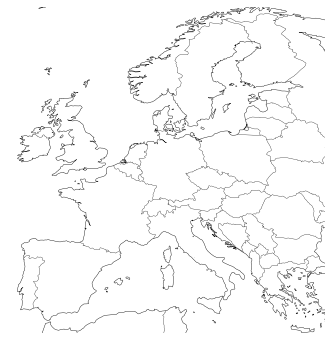

In [95]:
plot_congestion_rent(n, fn=f"{OUTPUT_SCENARIO}/map_congestion.pdf")

In [96]:
plot_line_loading(n, fn=f"{OUTPUT_SCENARIO}/map_avg_lineloading.pdf")

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:82

In [97]:
if H2_NETWORK:
    plot_pipeline_loading(
        n, min_capacity=1000, fn=f"{OUTPUT_SCENARIO}/map_avg_pipelineloading.pdf"
    )

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:82

## Stats: TWkm

In [26]:
def calculate_twkm(n, selection=None, decimals=1, which="optimal"):

    if selection is None:
        selection = [
            "H2 pipeline",
            "H2 pipeline retrofitted",
            "gas pipeline",
            "gas pipeline new",
            "DC",
        ]

    twkm = n.links.loc[n.links.carrier.isin(selection)]

    if which == "optimal":
        link_request = "p_nom_opt"
        line_request = "s_nom_opt"
    elif which == "added":
        link_request = "(p_nom_opt - p_nom)"
        line_request = "(s_nom_opt - s_nom)"
    elif which == "existing":
        link_request = "p_nom"
        line_request = "s_nom"

    twkm = twkm.eval(f"length*{link_request}").groupby(twkm.carrier).sum() / 1e6  # TWkm
    twkm["AC"] = n.lines.eval(f"length*{line_request}").sum() / 1e6  # TWkm

    twkm.index.name = None

    return twkm.round(decimals)

In [27]:
twkm = calculate_twkm(n, which="added")

In [28]:
twkm

DC                   99.5
H2 pipeline         179.0
gas pipeline          0.0
gas pipeline new      2.3
AC                  200.4
dtype: float64

## Stats: Energy Moved

In [29]:
def calculate_energy_moved(n, selection=None, decimals=1):

    if selection is None:
        selection = [
            "DC",
            "H2 pipeline",
            "H2 pipeline retrofitted",
            "gas pipeline",
            "gas pipeline_new",
        ]

    transport = n.links.query("carrier in @selection")

    df = (
        (n.snapshot_weightings.generators @ n.links_t.p0[transport.index].abs())
        .mul(transport.length)
        .groupby(transport.carrier)
        .sum()
    )

    df["AC"] = (
        (n.snapshot_weightings.generators @ n.lines_t.p0.abs())
        .mul(n.lines.length)
        .sum()
    )

    return df.div(1e12).round(decimals)  # EWhkm

In [30]:
calculate_energy_moved(n, decimals=2)

carrier
DC              0.75
H2 pipeline     1.23
gas pipeline    1.03
AC              1.67
dtype: float64

## Maps: Nodal Prices

In [103]:
def get_nodal_prices(n):

    return (
        n.buses_t.marginal_price.mean()
        .groupby([n.buses.location, n.buses.carrier])
        .first()
        .unstack()
    )

In [104]:
def plot_nodal_prices(df, geodf, carrier, label, vmin, vmax, cmap="Blues", fn=True):

    proj = ccrs.EqualEarth()
    geodf = geodf.to_crs(proj.proj4_init)

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": proj})

    geodf.plot(
        ax=ax,
        column=df[carrier].reindex(geodf.index),
        cmap=cmap,
        linewidths=0,
        legend=True,
        vmin=vmin,
        vmax=vmax,
        legend_kwds={
            "label": label,
            "shrink": 0.7,
            "extend": "max",
        },
    )

    ax.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)
    ax.add_feature(cartopy.feature.BORDERS.with_scale("50m"), linewidth=0.2, zorder=2)

    plt.gca().outline_patch.set_visible(False)
    ax.set_facecolor("white")

    if fn:
        if not isinstance(fn, str):
            fn = f"{OUTPUT_SCENARIO}/nodal-prices-{carrier}.pdf"
        plt.savefig(fn, bbox_inches="tight")
        plt.close()

In [105]:
df = get_nodal_prices(n)

In [106]:
carrier = "AC"
plot_nodal_prices(df, nodes, carrier, "mean electricity price [€/MWh]", 50, 120)

/tmp/ipykernel_117332/1044176266.py:26: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [107]:
carrier = "H2"
plot_nodal_prices(df, nodes, carrier, "mean hydrogen price [€/MWh]", 80, 140, "RdPu")

/tmp/ipykernel_117332/1044176266.py:26: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [108]:
carrier = "residential urban decentral heat"
plot_nodal_prices(
    df,
    nodes,
    carrier,
    "mean heat price [€/MWh]",
    0,
    80,
    "OrRd",
)

/tmp/ipykernel_117332/1044176266.py:26: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [109]:
carrier = "urban central heat"
plot_nodal_prices(df, nodes, carrier, "mean heat price [€/MWh]", 0, 80, "OrRd")

/tmp/ipykernel_117332/1044176266.py:26: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [110]:
carrier = "residential rural heat"
plot_nodal_prices(df, nodes, carrier, "mean heat price [€/MWh]", 0, 80, "OrRd")

/tmp/ipykernel_117332/1044176266.py:26: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [111]:
if GAS_NETWORK:
    carrier = "gas"
    plot_nodal_prices(df, nodes, carrier, "mean gas price [€/MWh]", 0, 30, "OrRd")

/tmp/ipykernel_117332/1044176266.py:26: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

## Maps: LCOE

In [112]:
def calculate_lcoe(n, carrier, p_nom_threshold=1000):

    gen_i = n.generators.loc[n.generators.carrier == carrier].index
    gen = n.snapshot_weightings.generators @ n.generators_t.p.loc[:, gen_i]

    oc = gen * n.generators.loc[gen_i, "marginal_cost"]
    ic = n.generators.eval("capital_cost * p_nom_opt").loc[gen_i]

    lcoe = (ic + oc) / gen

    lcoe = lcoe.where(n.generators.p_nom_opt > p_nom_threshold).dropna()

    lcoe.index = lcoe.index.map(n.generators.bus.map(n.buses.location))

    return lcoe

In [113]:
def plot_lcoe(n, geodf, carrier, label, vmin, vmax, cmap="Blues", fn=True):

    lcoe = calculate_lcoe(n, carrier)

    proj = ccrs.EqualEarth()
    geodf = geodf.to_crs(proj.proj4_init)

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": proj})

    geodf.plot(
        ax=ax,
        column=lcoe.reindex(geodf.index),
        cmap=cmap,
        linewidths=0,
        legend=True,
        vmin=vmin,
        vmax=vmax,
        legend_kwds={
            "label": label,
            "shrink": 0.7,
            "extend": "max",
        },
    )

    ax.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)
    ax.add_feature(cartopy.feature.BORDERS.with_scale("50m"), linewidth=0.2, zorder=2)

    plt.gca().outline_patch.set_visible(False)
    ax.set_facecolor("white")

    plt.xlim(-1e6, 2.6e6)
    plt.ylim(4.3e6, 7.8e6)

    if fn:
        if not isinstance(fn, str):
            fn = f"{OUTPUT_SCENARIO}/lcoe-{carrier}.pdf"
        plt.savefig(fn, bbox_inches="tight")

    plt.close()

In [114]:
plot_lcoe(n, nodes, "onwind", "onshore wind LCOE [€/MWh]", 0, 100)

/tmp/ipykernel_117332/2414765065.py:28: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [115]:
plot_lcoe(n, offnodes, "offwind-dc", "offshore wind (DC) LCOE [€/MWh]", 0, 100)

/tmp/ipykernel_117332/2414765065.py:28: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [116]:
plot_lcoe(n, offnodes, "offwind-ac", "offshore wind (AC) LCOE [€/MWh]", 0, 100)

/tmp/ipykernel_117332/2414765065.py:28: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [117]:
plot_lcoe(n, nodes, "solar rooftop", "rooftop solar LCOE [€/MWh]", 0, 100, "Oranges")

/tmp/ipykernel_117332/2414765065.py:28: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [118]:
plot_lcoe(n, nodes, "solar", "utility solar LCOE [€/MWh]", 0, 100, "Oranges")

/tmp/ipykernel_117332/2414765065.py:28: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

## Maps: Market Values

In [119]:
def market_values(n, carrier="onwind"):

    gen = n.generators_t.p.loc[:, n.generators.carrier == carrier]
    gen.columns = gen.columns.map(n.generators.bus)

    lmp = n.buses_t.marginal_price.loc[:, gen.columns]

    mv = (gen * lmp).sum() / gen.sum()

    mv.index = mv.index.map(n.buses.location)

    return mv

In [120]:
def plot_market_values(n, geodf, carrier, label, cmap="Blues", fn=True):

    mv = market_values(n, carrier)

    proj = ccrs.EqualEarth()
    geodf = geodf.to_crs(proj.proj4_init)

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": proj})

    geodf.plot(
        ax=ax,
        column=mv.reindex(geodf.index),
        cmap=cmap,
        linewidths=0,
        legend=True,
        # vmin=vmin,
        # vmax=vmax,
        legend_kwds={
            "label": label,
            "shrink": 0.7,
            # "extend": "max",
        },
    )

    ax.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)
    ax.add_feature(cartopy.feature.BORDERS.with_scale("50m"), linewidth=0.2, zorder=2)

    plt.gca().outline_patch.set_visible(False)
    ax.set_facecolor("white")

    if fn:
        if not isinstance(fn, str):
            fn = f"{OUTPUT_SCENARIO}/market-values-{carrier}.pdf"
        plt.savefig(fn, bbox_inches="tight")
        plt.close()

In [121]:
plot_market_values(n, nodes, "solar", "utility-solar market value [€/MWh]", "Oranges")

/tmp/ipykernel_117332/1822320880.py:28: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [122]:
plot_market_values(
    n, nodes, "solar rooftop", "rooftop solar market value [€/MWh]", "Oranges"
)

/tmp/ipykernel_117332/1822320880.py:28: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [123]:
plot_market_values(n, nodes, "onwind", "onshore wind market value [€/MWh]", "Blues")

/tmp/ipykernel_117332/1822320880.py:28: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [124]:
plot_market_values(
    n, offnodes, "offwind-dc", "offshore wind (DC) market value [€/MWh]", "Blues"
)

/tmp/ipykernel_117332/1822320880.py:28: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [125]:
plot_market_values(
    n, offnodes, "offwind-ac", "offshore wind (AC) market value [€/MWh]", "Blues"
)

/tmp/ipykernel_117332/1822320880.py:28: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [126]:
plot_market_values(n, nodes, "ror", "run-of-river market value [€/MWh]", "Greens")

/tmp/ipykernel_117332/1822320880.py:28: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

## Potential Used

In [127]:
def potential_used(n):
    return (
        n.generators.eval("p_nom_opt/p_nom_max*100")
        .groupby([n.generators.bus.map(n.buses.location), n.generators.carrier])
        .sum()
        .unstack()
        .drop("EU")
    )

In [128]:
def plot_potential_used(df, geodf, carrier, cmap="Blues", fn=True):

    proj = ccrs.EqualEarth()
    geodf = geodf.to_crs(proj.proj4_init)

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": proj})

    geodf.plot(
        ax=ax,
        column=df[carrier].reindex(geodf.index),
        # transform=ccrs.PlateCarree(),
        cmap=cmap,
        linewidths=0,
        legend=True,
        vmax=100,
        vmin=0,
        legend_kwds={
            "label": "share of technical potential used [%]",
            "shrink": 0.7,
        },
    )

    ax.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)
    ax.add_feature(cartopy.feature.BORDERS.with_scale("50m"), linewidth=0.2, zorder=2)

    plt.gca().outline_patch.set_visible(False)
    ax.set_facecolor("white")

    if fn:
        if not isinstance(fn, str):
            fn = f"{OUTPUT_SCENARIO}/potential-used-onw-{carrier}.pdf"
        plt.savefig(fn, bbox_inches="tight")
        plt.close()

In [129]:
df = potential_used(n)

In [130]:
plot_potential_used(df, offnodes, "offwind-ac")

/tmp/ipykernel_117332/3572162403.py:26: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [131]:
plot_potential_used(df, offnodes, "offwind-dc")

/tmp/ipykernel_117332/3572162403.py:26: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [132]:
plot_potential_used(df, nodes, "onwind")

/tmp/ipykernel_117332/3572162403.py:26: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [133]:
plot_potential_used(df, nodes, "solar", cmap="Oranges")

/tmp/ipykernel_117332/3572162403.py:26: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [134]:
plot_potential_used(df, nodes, "solar rooftop", cmap="Oranges")

/tmp/ipykernel_117332/3572162403.py:26: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

## Import and Export

In [135]:
def get_import_export_balance(n):

    io = pd.DataFrame()

    io["oil"] = get_import_export_oil().eval("demand - supply")

    balance = nodal_balance(n, "AC", aggregate=["snapshot"])
    h2_balance = nodal_balance(n, "H2", aggregate=["snapshot"])
    io["hydrogen"] = (
        h2_balance.droplevel(0)
        .unstack("carrier")
        .filter(like="H2 pipeline")
        .sum(axis=1)
    ).div(1e6)

    ac_balance = nodal_balance(n, "AC", aggregate=["snapshot"])
    io["electricity"] = (
        ac_balance.droplevel(0).unstack("carrier")[["AC", "DC"]].sum(axis=1).div(1e6)
    )

    if GAS_NETWORK:

        gas_balance = nodal_balance(n, "gas", aggregate=["snapshot"])

        io["gas"] = (
            gas_balance.groupby(["bus", "carrier"])
            .sum()
            .unstack()
            .filter(like="gas pipeline")
            .sum(axis=1)
            .div(1e6)
        )

    else:

        io["gas"] = get_import_export_gas().eval("demand - supply")

    io["total"] = io.sum(axis=1)

    return io.fillna(0.0)

In [136]:
def plot_import_export(
    df,
    geodf,
    carrier,
    cmap="PiYG",
    unit="TWh",
    fn=True,
    lim=None,
    lorenz=False,
    dfs={},
):

    crs = ccrs.EqualEarth()
    geodf = geodf.to_crs(crs.proj4_init)

    if lim is None:
        lim = df[carrier].abs().max()

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": crs})

    geodf.plot(
        ax=ax,
        column=-df[carrier].reindex(geodf.index),
        cmap=cmap,
        linewidths=0,
        legend=True,
        vmin=-lim,
        vmax=lim,
        legend_kwds={
            "label": f"{carrier} balance [{unit}]",
            "shrink": 0.7,
        },
    )

    ax.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)
    ax.add_feature(cartopy.feature.BORDERS.with_scale("50m"), linewidth=0.2, zorder=2)

    plt.gca().outline_patch.set_visible(False)
    ax.set_facecolor("white")

    if lorenz:
        axins = ax.inset_axes([0.05, 0.77, 0.27, 0.23])
        carriers = ["AC", "H2", "gas", "oil"]  # if GAS_NETWORK else ["AC", "H2"]
        plot_lorenz_inset(axins, n, carriers, dfs=dfs)

    if fn:
        if not isinstance(fn, str):
            fn = f"{OUTPUT_SCENARIO}/import-export-{carrier}-{lim}.pdf"
        plt.savefig(fn, bbox_inches="tight")
        plt.close()

In [137]:
def plot_lorenz_inset(ax, n, carriers, sortby="supply/demand", dfs={}):

    for c in set(carriers).difference(dfs.keys()):
        dfs[c] = None

    linspace = np.linspace(0, 100, 100)
    ax.plot(linspace, linspace, c="darkgrey", linestyle=":", linewidth=1)

    nice_names = {
        "AC": "electricity",
        "H2": "hydrogen",
        "gas": "methane",
        "oil": "oil",
    }

    for carrier in carriers:
        df = cumulative_share(n, carrier, sortby, df=dfs[carrier])
        ax.plot(
            df.demand,
            df.supply,
            label=nice_names[carrier],
            color=tech_colors[nice_names[carrier]],
            linewidth=1,
        )

    ax.set_xlabel(f"Demand [%]", fontsize=9, backgroundcolor="white", labelpad=-7)
    ax.set_ylabel(f"Supply [%]", fontsize=9, backgroundcolor="white", labelpad=-10)
    ax.set_ylim(-1, 101)
    ax.set_xlim(-1, 101)
    ax.tick_params(labelsize=8)
    ax.legend(fontsize=9, bbox_to_anchor=(0.99, 1.03), frameon=False)
    for i in ["top", "right", "left", "bottom"]:
        ax.spines[i].set_visible(False)

In [138]:
io = get_import_export_balance(n)

In [139]:
dfs = {"oil": get_import_export_oil()}
if not GAS_NETWORK:
    dfs["gas"] = get_import_export_gas()

In [140]:
plot_import_export(io, nodes, "electricity", cmap="PRGn", lim=200)

/tmp/ipykernel_117332/1074536397.py:38: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [141]:
plot_import_export(io, nodes, "electricity", cmap="PRGn", lim=100)

/tmp/ipykernel_117332/1074536397.py:38: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [142]:
plot_import_export(io, nodes, "hydrogen", cmap="PRGn", lim=200)

/tmp/ipykernel_117332/1074536397.py:38: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [143]:
plot_import_export(io, nodes, "gas", cmap="PRGn", lim=200)
plot_import_export(io, nodes, "gas", cmap="PRGn", lim=40)

/tmp/ipykernel_117332/1074536397.py:38: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [144]:
plot_import_export(io, nodes, "oil", cmap="PRGn", lim=200)
plot_import_export(io, nodes, "oil", cmap="PRGn", lim=40)

/tmp/ipykernel_117332/1074536397.py:38: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [145]:
plot_import_export(io, nodes, "total", cmap="PRGn", lim=200, lorenz=True, dfs=dfs)

/tmp/ipykernel_117332/1074536397.py:38: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

## Capacities Built

In [146]:
def plot_capacity_built(df, geodf, carrier, cmap="Blues", unit="GW", fn=None):

    proj = ccrs.EqualEarth()
    geodf = geodf.to_crs(proj.proj4_init)

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": proj})

    geodf.plot(
        ax=ax,
        column=df[carrier].reindex(geodf.index),
        cmap=cmap,
        linewidths=0,
        legend=True,
        vmin=0,
        legend_kwds={
            "label": f"{carrier} capacity [{unit}]",
            "shrink": 0.7,
        },
    )

    ax.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)
    ax.add_feature(cartopy.feature.BORDERS.with_scale("50m"), linewidth=0.2, zorder=2)

    plt.gca().outline_patch.set_visible(False)
    ax.set_facecolor("white")

    if fn is None:
        plt.savefig(
            f"{OUTPUT_SCENARIO}/capacities-built-{carrier}.pdf", bbox_inches="tight"
        )
        plt.close()

In [147]:
p_caps = pd.concat(
    [
        n.generators.groupby([n.generators.bus.map(n.buses.location), "carrier"])
        .p_nom_opt.sum()
        .unstack()
        .drop(["oil", "gas"], axis=1),
        n.links.groupby([n.links.bus0.map(n.buses.location), "carrier"])
        .p_nom_opt.sum()
        .unstack()
        .drop(["DC", "H2 pipeline"], axis=1, errors="ignore"),
        n.storage_units.groupby([n.storage_units.bus.map(n.buses.location), "carrier"])
        .p_nom_opt.sum()
        .unstack(),
    ],
    axis=1,
).div(
    1e3
)  # GW

p_caps = p_caps.loc[:, p_caps.count() > 1]

In [148]:
for i in p_caps.columns:

    if "off" in i:
        gdf = offnodes
    else:
        gdf = nodes

    if "wind" in i:
        cmap = "Blues"
    elif "heat" in i or "water tank" in i:
        cmap = "Reds"
    elif "solar" in i:
        cmap = "Oranges"
    elif i in ["hydro", "PHS", "ror"]:
        cmap = "GnBu"
    elif "H2" in i or i in ["Fischer-Tropsch", "Sabatier"]:
        cmap = "RdPu"
    elif "battery" in i or "distribution" in i or "BEV" in i or "V2G" in i:
        cmap = "Greens"

    if p_caps[i].max() > 1:
        plot_capacity_built(p_caps, gdf, i, cmap);

/tmp/ipykernel_117332/1081631657.py:24: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

In [149]:
e_caps = (
    n.stores.groupby([n.stores.bus.map(n.buses.location), "carrier"])
    .e_nom_opt.sum()
    .unstack()
    .div(1e3)
)  # GWh
e_caps = e_caps.loc[:, e_caps.count() > 1]

In [150]:
for i in e_caps.columns:

    if "water tank" in i:
        cmap = "Reds"
    elif "solar" in i:
        cmap = "Oranges"
    elif "H2" in i or "gas" in i:
        cmap = "RdPu"
    elif "battery" in i or "Li ion":
        cmap = "Greens"

    if e_caps[i].max() > 1:
        plot_capacity_built(e_caps, nodes, i, cmap, unit="GWh");

/tmp/ipykernel_117332/1081631657.py:24: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

## Utilisation Factor Time Series

In [151]:
def aggregate_techs(tech):
    if "solar thermal" in tech:
        return "solar thermal"
    elif "solar" in tech:
        return "solar PV"
    elif "offwind" in tech:
        return "offshore wind"
    elif "onwind" in tech:
        return "onshore wind"
    elif "ror" in tech:
        return "run of river"
    elif "ground heat pump" in tech:
        return "ground-sourced heat pump"
    elif "air heat pump" in tech:
        return "air-sourced heat pump"
    elif "water tank" in tech:
        return "thermal energy storage"
    elif tech == "H2":
        return "hydrogen storage"
    elif tech == "Li ion":
        return "electric vehicle batteries"
    elif "gas boiler" in tech:
        return "gas boiler"
    elif "resistive heater" in tech:
        return "resistive heater"
    elif "CHP" in tech:
        return "CHP"
    else:
        return tech

In [152]:
def unstack_day_hour(cfc):

    df = cfc.groupby(cfc.index.hour).agg(list)

    columns = pd.date_range(cfc.index[0], cfc.index[-1], freq="D").strftime("%-d %b")

    return pd.DataFrame(df.tolist(), index=df.index, columns=columns)

In [153]:
def plot_cf_heatmap(
    df, vmin=0, vmax=80, cmap="Greens", label="capacity factors [%]", fn=True
):
    fig, ax = plt.subplots(figsize=(6, 2.5))
    sns.heatmap(
        df,
        cmap=cmap,
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        cbar_kws=dict(label=label, extend="max"),
    )
    plt.ylabel("hour of the day")
    plt.xlabel("day of the year")
    plt.yticks(rotation=0)
    plt.title(carrier, fontsize=12)
    plt.tight_layout()
    if fn:
        if not isinstance(fn, str):
            fn = f"{OUTPUT_SCENARIO}/cf-ts-{carrier}.pdf"
        plt.savefig(fn, bbox_inches="tight")
        plt.close()

In [154]:
cf = n.buses_t.marginal_price.groupby(n.buses.carrier, axis=1).mean()

In [155]:
# for carrier in cf.columns:
for carrier in ["AC", "H2"]:
    cfc = cf[carrier]
    df = unstack_day_hour(cfc)
    vmax = np.ceil(cfc.quantile(0.99) / 10) * 10
    if carrier in ["AC", "H2"]:
        vmax = 300
    plot_cf_heatmap(
        df,
        cmap="Spectral_r",
        label="Nodal Price [EUR/MWh]",
        vmax=vmax,
        fn=f"{OUTPUT_SCENARIO}/price-ts-{carrier}.pdf",
    )

In [156]:
cf = n.links_t.p_max_pu.groupby(n.links.carrier, axis=1).mean() * 100
cf = cf.groupby(cf.columns.map(aggregate_techs), axis=1).mean()

In [157]:
for carrier in cf.columns:
    cfc = cf[carrier]
    df = unstack_day_hour(cfc)
    plot_cf_heatmap(df, cmap="viridis", vmin=40, vmax=100)

In [158]:
cf = (
    n.stores_t.e.groupby(n.stores.carrier, axis=1).sum()
    / n.stores.e_nom_opt.groupby(n.stores.carrier).sum()
    * 100
)
cf = cf.groupby(cf.columns.map(aggregate_techs), axis=1).mean()

In [159]:
for carrier in cf.columns:
    cfc = cf[carrier]
    df = unstack_day_hour(cfc)
    plot_cf_heatmap(df, cmap="Purples", vmin=0, vmax=100, label="SOC [%]")

In [160]:
cf = (
    n.links_t.p0.groupby(n.links.carrier, axis=1).sum()
    / n.links.p_nom_opt.groupby(n.links.carrier).sum()
    * 100
)
cf = cf.groupby(cf.columns.map(aggregate_techs), axis=1).mean()

In [161]:
bidirectional = (cf < 0).any()

In [162]:
cfb = cf.loc[:, ~bidirectional]
for carrier in cfb.columns:
    cfc = cfb[carrier]
    df = unstack_day_hour(cfc)
    plot_cf_heatmap(df, cmap="Reds", vmax=100)

In [163]:
cfb = cf.loc[:, bidirectional]
for carrier in cfb.columns:
    cfc = cfb[carrier]
    df = unstack_day_hour(cfc)
    plot_cf_heatmap(df, cmap="RdBu", vmin=-100, vmax=100)

In [164]:
cf = n.generators_t.p_max_pu.groupby(n.generators.carrier, axis=1).mean() * 100
cf = cf.groupby(cf.columns.map(aggregate_techs), axis=1).mean()

In [165]:
for carrier in cf.columns:
    cfc = cf[carrier]
    df = unstack_day_hour(cfc)
    plot_cf_heatmap(df, cmap="Blues", fn=f"{OUTPUT}/cf-raw-ts-{carrier}.pdf")

In [166]:
cf = n.links_t.efficiency.groupby(n.links.carrier, axis=1).mean()
cf = cf.groupby(cf.columns.map(aggregate_techs), axis=1).mean()

In [167]:
for carrier in cf.columns:
    cfc = cf[carrier]
    df = unstack_day_hour(cfc)
    plot_cf_heatmap(
        df,
        vmin=1,
        vmax=4,
        cmap="Greens",
        label="COP [-]",
        fn=f"{OUTPUT}/cop-ts-{carrier}.pdf",
    )

## Maps: Utilisation Factors

In [168]:
grouper = [n.links.carrier, n.links.bus0.map(n.buses.location)]

In [169]:
c = n.links.p_nom_opt.groupby(grouper).sum()
c = c.where(c > 250)

In [170]:
cf = n.links_t.p0.groupby(grouper, axis=1).sum() / c * 100

In [171]:
df = cf.mean().unstack(0)

In [172]:
def plot_utilisation_factors(
    df, geodf, carrier, label, vmin=0, vmax=100, cmap="Blues", fn=True
):

    proj = ccrs.EqualEarth()
    geodf = geodf.to_crs(proj.proj4_init)

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": proj})

    geodf.plot(
        ax=ax,
        column=df[carrier].reindex(geodf.index),
        cmap=cmap,
        linewidths=0,
        legend=True,
        vmin=vmin,
        vmax=vmax,
        legend_kwds={
            "label": label,
            "shrink": 0.7,
            # "extend": "max",
        },
    )

    ax.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)
    ax.add_feature(cartopy.feature.BORDERS.with_scale("50m"), linewidth=0.2, zorder=2)

    bounds = geodf.total_bounds
    plt.xlim([bounds[0], bounds[2]])
    plt.ylim([bounds[1], bounds[3]])

    plt.gca().outline_patch.set_visible(False)
    ax.set_facecolor("white")

    if fn:
        if not isinstance(fn, str):
            fn = f"{OUTPUT_SCENARIO}/utilisation-factors-{carrier}.pdf"
        plt.savefig(fn, bbox_inches="tight")
        plt.close()

In [173]:
for tech in df.filter(
    regex="(Sabatier|electricity distribution grid|H2 Electrolysis|H2 Fuel Cell|Fischer-Tropsch)"
).columns:
    plot_utilisation_factors(
        df, nodes, tech, f"{tech} Utilisation Factor [%]", cmap="RdPu"
    )

/tmp/ipykernel_117332/3923454283.py:32: DeprecationWarning:

The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the 

## Balance Time Series

In [ ]:
def rename_techs_tyndp(tech):
    tech = rename_techs(tech)
    # if "heat pump" in tech or "resistive heater" in tech:
    #    return "power-to-heat"
    # elif tech in ["H2 Electrolysis", "methanation", "helmeth", "H2 liquefaction"]:
    #    return "power-to-gas"
    if tech == "H2":
        return "H2 storage"
    # elif tech in ["OCGT", "CHP", "gas boiler", "H2 Fuel Cell"]:
    #    return "gas-to-power/heat"
    # elif "solar" in tech:
    #    return "solar"
    elif tech == "Fischer-Tropsch":
        return "power-to-liquid"
    elif "offshore wind" in tech:
        return "offshore wind"
    #    if "heat pump" in tech:
    #        return "heat pump"
    elif tech == "gas":
        return "fossil gas"
    # elif "CC" in tech or "sequestration" in tech:
    #    return "CCS"
    elif tech in ["industry electricity", "agriculture electricity"]:
        return "industry electricity"
    elif "oil emissions" in tech:
        return "oil emissions"
    else:
        return tech

In [ ]:
preferred_order = pd.Index(
    [
        "H2 storage",
        "hydrogen storage",
        "battery storage",
        "BEV charger",
        "V2G",
        "hot water storage",
        "co2",
        "hydroelectricity",
        "hydro reservoir",
        "pumped hydro storage",
        "run of river",
        "transmission lines",
        "electricity distribution grid",
        "solid biomass",
        "biogas",
        "onshore wind",
        "offshore wind",
        "offshore wind (AC)",
        "offshore wind (DC)",
        "solar PV",
        "solar thermal",
        "solar rooftop",
        "solar",
        "building retrofitting" "ground heat pump",
        "air heat pump",
        "heat pump",
        "resistive heater",
        "power-to-heat",
        "gas-to-power/heat",
        "CHP",
        "OCGT",
        "gas boiler",
        "gas",
        "natural gas",
        "helmeth",
        "methanation",
        "power-to-gas",
        "power-to-H2",
        "H2 pipeline",
        "H2 pipeline retrofitted",
        "gas pipeline",
        "gas pipeline new",
        "H2 liquefaction",
        "power-to-liquid",
        "CO2 sequestration",
        "CCS",
    ]
)

In [ ]:
def datetime_xticks(
    df,
    ax,
    number_timestamps=10,
    minor_attr="day",
    minor_fmt="%d",
    major_attr="month",
    major_fmt="%b",
):
    # https://stackoverflow.com/questions/30133280/pandas-bar-plot-changes-date-format

    # Create list of monthly timestamps by selecting the first weekly timestamp of each
    # month (in this example, the first Sunday of each month)
    daily_timestamps = [
        timestamp
        for idx, timestamp in enumerate(df.index)
        if (getattr(timestamp, minor_attr) != getattr(df.index[idx - 1], minor_attr))
        | (idx == 0)
    ]

    # Automatically select appropriate number of timestamps so that x-axis does
    # not get overcrowded with tick labels
    step = 1
    while len(daily_timestamps[::step]) > number_timestamps:
        step += 1
    timestamps = daily_timestamps[::step]

    # Create tick labels from timestamps
    labels = [
        ts.strftime(f"{minor_fmt}\n{major_fmt}")
        if (getattr(ts, major_attr) != getattr(timestamps[idx - 1], major_attr))
        | (idx == 0)  # | (idx == len(timestamps)-1)
        else ts.strftime(minor_fmt)
        for idx, ts in enumerate(timestamps)
    ]

    # Set major ticks and labels
    ax.set_xticks([df.index.get_loc(ts) for ts in timestamps])
    ax.set_xticklabels(labels)

    # Set minor ticks without labels
    ax.set_xticks([df.index.get_loc(ts) for ts in daily_timestamps], minor=True)

    # Rotate and center labels
    ax.figure.autofmt_xdate(rotation=0, ha="center")

In [ ]:
def plot_balance_timeseries(
    n, carrier, time, ylims=None, resample="", balance=None, fn=True
):

    if balance is None:
        balance = nodal_balance(n, carrier, time=time, energy=False)

    df = balance.groupby(["carrier", "snapshot"]).sum().unstack(0).div(1e3)

    df = df.groupby(df.columns.map(rename_techs_tyndp), axis=1).sum()

    if resample:
        df = df.resample(resample).mean()

    df = df.loc[:, ~df.columns.isin(["H2 pipeline", "transmission lines"])]

    order = preferred_order.intersection(df.columns).append(
        df.columns.difference(preferred_order)
    )
    df = df.loc[:, order]

    colors = df.columns.map(tech_colors)

    fig, ax = plt.subplots(figsize=(10, 4))

    dft = df.loc[time]

    pos = dft.where(dft > 0)
    neg = dft.where(dft < 0)

    kwargs = dict(ax=ax, linewidth=0, color=colors, width=1.0)

    pos.plot.bar(**kwargs, stacked=True)
    neg.plot.bar(**kwargs, stacked=True)

    handles, labels = ax.get_legend_handles_labels()

    half = int(len(handles) / 2)
    plt.legend(
        handles=handles[:half],
        labels=labels[:half],
        bbox_to_anchor=(1, 1.05),
    )

    if ylims is None:
        ylim = np.ceil(max(-neg.sum(axis=1).min(), pos.sum(axis=1).max()) / 100) * 100
    else:
        ylim = ylims[carrier] if isinstance(ylims, dict) else ylims

    plt.ylim([-ylim, ylim])
    plt.xlabel("")
    unit = "kt/h" if "co2" in carrier else "GW"
    plt.ylabel(f"{carrier} balance [{unit}]")

    if "W" in resample or "D" in resample:
        datetime_xticks(
            dft, ax, number_timestamps=12, minor_attr="month", minor_fmt="%d"
        )
    else:
        datetime_xticks(dft, ax)

    ax.axhline(0, color="grey", linewidth=0.5)

    if fn:
        if not isinstance(fn, str):
            fn = f"{OUTPUT_SCENARIO}/ts-balance-{carrier}-{resample}-{time}.pdf"
        plt.savefig(fn, bbox_inches="tight")
        plt.close()

In [ ]:
carriers = [
    "AC",
    "co2",
    "co2 stored",
    "gas",
    "H2",
    "residential rural heat",
    "services rural heat",
    "residential urban decentral heat",
    "services urban decentral heat",
    "urban central heat",
    "oil",
    "low voltage",
]

In [ ]:
ylims = {
    "AC": 2200,
    "co2": 150,
    "co2 stored": 100,
    "gas": 700,
    "H2": 800,
    "residential rural heat": 200,
    "services rural heat": 100,
    "residential urban decentral heat": 200,
    "services urban decentral heat": 100,
    "urban central heat": 600,
    "oil": 200,
    "low voltage": 1000,
}

In [ ]:
months = pd.date_range("2013-01", "2014-01", freq="M", closed="right").format(
    formatter=lambda x: x.strftime("%Y-%m")
)

In [ ]:
months = ["2013-02", "2013-07"]

In [ ]:
def multiprocess(f, variants, nprocesses=2):

    nprocesses = min(mp.cpu_count(), nprocesses)

    with mp.Pool(processes=nprocesses) as pool:
        x = pool.starmap(f, variants)

In [ ]:
variants = [(n, x, y, ylims) for x in carriers for y in months]
multiprocess(plot_balance_timeseries, variants, 4)

In [ ]:
variants = [(n, carrier, "2013", ylims, "D") for carrier in carriers]
multiprocess(plot_balance_timeseries, variants)

In [ ]:
heat_nodes = [
    "residential rural heat",
    "services rural heat",
    "residential urban decentral heat",
    "services urban decentral heat",
    "urban central heat",
]

In [ ]:
ylim = 1200
for month in months:
    balance = nodal_balance(n, heat_nodes, time=month, energy=False)
    plot_balance_timeseries(n, "total heat", month, ylims=ylim, balance=balance)

In [ ]:
balance = nodal_balance(n, heat_nodes, time="2013", energy=False)
plot_balance_timeseries(
    n, "total heat", "2013", resample="D", ylims=1200, balance=balance
)

In [ ]:
elec_nodes = [
    "AC",
    "low voltage",
]
ylim = 2400

In [ ]:
for month in months:
    balance = nodal_balance(n, elec_nodes, time=month, energy=False)
    plot_balance_timeseries(n, "total electricity", month, ylims=ylim, balance=balance)

In [ ]:
balance = nodal_balance(n, elec_nodes, time="2013", energy=False)
plot_balance_timeseries(
    n, "total electricity", "2013", resample="D", ylims=ylim, balance=balance
)

## Playground

In [ ]:
c = [
    "AC",
    "H2",
    "residential rural heat",
    "services rural heat",
    "residential urban decentral heat",
    "services urban decentral heat",
    "urban central heat",
]

In [ ]:
df = nodal_balance(n, "AC", energy=False)

In [ ]:
pos = (
    df.where(df > 0)
    .dropna()
    .droplevel("component")
    .unstack("snapshot")
    .fillna(0)
    .mean(axis=1)
    .unstack()
)
pos = pos.drop(
    pos.columns.intersection(["AC", "DC", "H2 pipeline", "H2 pipeline retrofitted"]),
    axis=1,
)
pos = pos.sum(axis=1).div(1e3)

In [ ]:
neg = (
    df.where(df < 0)
    .dropna()
    .droplevel("component")
    .unstack("snapshot")
    .fillna(0)
    .mean(axis=1)
    .unstack()
)
neg = neg.drop(
    neg.columns.intersection(["AC", "DC", "H2 pipeline", "H2 pipeline retrofitted"]),
    axis=1,
)
neg = neg.sum(axis=1).div(-1e3)

In [ ]:
s = pos - neg

In [ ]:
(pos / s).sort_values().reset_index(drop=True).plot(ylim=(-40, 40))
plt.savefig(
    f"{OUTPUT_SCENARIO}/imbalance-rate-curve-electricity-pos.pdf", bbox_inches="tight"
)

In [ ]:
(neg / s).sort_values().reset_index(drop=True).plot(ylim=(-40, 40))
plt.savefig(
    f"{OUTPUT_SCENARIO}/imbalance-rate-curve-electricity-neg.pdf", bbox_inches="tight"
)

In [ ]:
def plot_imbalance_rate(
    s,
    geodf,
    carrier,
    label="",
    cmap="PiYG",
    limit="symmetric",
    vmax=None,
    vmin=None,
    fn=True,
):

    proj = ccrs.EqualEarth()
    geodf = geodf.to_crs(proj.proj4_init)

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": proj})

    if limit == "symmetric":
        lim = max(s.max(), s.min())
        vmin = -lim
        vmax = lim

    geodf.plot(
        ax=ax,
        column=s.reindex(geodf.index),
        # transform=ccrs.PlateCarree(),
        cmap=cmap,
        linewidths=0,
        legend=True,
        vmax=vmax,
        vmin=vmin,
        legend_kwds={
            "label": label,
            "shrink": 0.7,
            "extend": "both",
        },
    )

    ax.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)
    ax.add_feature(cartopy.feature.BORDERS.with_scale("50m"), linewidth=0.2, zorder=2)

    plt.gca().outline_patch.set_visible(False)
    ax.set_facecolor("white")

    if fn:
        if not isinstance(fn, str):
            fn = f"{OUTPUT_SCENARIO}/imbalance-rate-{carrier}.pdf"
        plt.savefig(fn, bbox_inches="tight")
        plt.close()

In [ ]:
plot_imbalance_rate(
    pos / s,
    nodes,
    "electricity-pos",
    "electricity average positive injection\nover average net injection [-]",
    vmax=20,
    vmin=-20,
    limit=None,
)

In [ ]:
plot_imbalance_rate(
    neg / s,
    nodes,
    "electricity-neg",
    "electricity average positive injection\nover average net injection [-]",
    vmax=20,
    vmin=-20,
    limit=None,
)

In [ ]:
e = n.links.query("carrier == 'H2 Electrolysis'").set_index("bus0").p_nom_opt

In [ ]:
df = (
    n.generators.filter(regex="(solar$|solar rooftop)", axis=0)
    .groupby("bus")
    .p_nom_opt.sum()
    .reindex(n.buses.location)
)  # .groupby('index').sum()
s = df.groupby(df.index).sum().drop("EU")

In [ ]:
np.corrcoef(e, s)

In [ ]:
df = nodal_balance(
    n, ["AC", "low-voltage"], aggregate=["component", "bus"], energy=False
)

In [ ]:
n.loads.carrier.unique()

In [ ]:
as_dense(n, "Load", "p_set").loc[
    :, n.loads.carrier.str.contains("industry electricity")
].sum(axis=1)

In [ ]:
(
    n.links_t.p0.filter(
        regex="(H2 Electrolysis|battery charger|BEV charger|heat pump|resistive heater)",
        axis=1,
    ).sum(axis=1)
    + as_dense(n, "Load", "p_set")
    .loc[:, n.loads.carrier.str.contains("industry electricity")]
    .sum(axis=1)
).div(
    1e3
).max()  # GW

In [ ]:
n.links.carrier.unique()

In [ ]:
df.where(df < 0).dropna().unstack().fillna(0).mul(-1e-3).plot.area()

In [ ]:
df = n.links.filter(regex="(OCGT|CHP|Fuel Cell)", axis=0)

cap = df.eval("p_nom_opt * efficiency").groupby(df.carrier).sum().div(1e3)  # GW

In [ ]:
cap

In [ ]:
cap.sum()

In [ ]:
h2_storage = n.stores.query("carrier == 'H2'")
nodes["H2"] = h2_storage.rename(
    index=h2_storage.bus.map(n.buses.location)
).e_nom_opt.div(
    1e6
)  # TWh

proj = ccrs.EqualEarth()
nodes = nodes.to_crs(proj.proj4_init)

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": proj})

nodes.plot(
    ax=ax,
    column="H2",
    cmap="Greens",
    linewidths=0,
    legend=True,
    legend_kwds={
        "label": "Hydrogen Storage [TWh]",
        "shrink": 0.7,
        "extend": "max",
    },
)

plt.gca().outline_patch.set_visible(False)
ax.set_facecolor("white")

In [ ]:
df = nodal_balance(n, elec_nodes, energy=False)

In [ ]:
df = (
    df.groupby(["carrier", "snapshot"])
    .sum()
    .unstack(0)
    .div(1e3)
    .drop(["AC", "DC"], axis=1)
)

In [ ]:
df.where(df < 0).sum(axis=1).mul(-1).max()

In [ ]:
df = df.loc[:, ~df.columns.isin(["H2 pipeline", "transmission lines"])]

In [ ]:
(-n.snapshot_weightings.generators @ n.links_t.p1.filter(like="DAC", axis=1)).sum()

In [ ]:
(n.snapshot_weightings.generators @ n.loads_t.p_set.filter(like="IE")).div(
    1e6
)  # .sum()

In [ ]:
a = n.links.filter(like="H2 Electrolysis", axis=0).groupby("bus0").p_nom_opt.sum()

In [ ]:
b = n.generators.filter(like="offwind", axis=0).groupby("bus").p_nom_opt.sum()

In [ ]:
a

In [ ]:
np.corrcoef(a.reindex_like(b), b)

In [ ]:
n.links.query("carrier == 'H2 pipeline'").eval("capital_cost / length").mean()

In [ ]:
n.stores.query("carrier == 'H2' and capital_cost < 145").e_nom_opt.sum()

In [ ]:
n.stores.query(
    "carrier == 'H2' and capital_cost > 145"
).e_nom_opt.sum() / n.stores.query("carrier == 'H2'").e_nom_opt.sum()

In [ ]:
n.stores_t.e.filter(like="H2", axis=1).sum(axis=1).plot()

In [ ]:
n.stores_t.e.filter(like="H2", axis=1).sum(axis=1).plot()

In [ ]:
df = nodal_balance(n, "H2", aggregate=["snapshot"])

In [ ]:
df = df.groupby(["bus", "carrier"]).sum().unstack("carrier")

In [ ]:
link_loading = n.links_t.p0.abs().mean() / n.links.p_nom_opt * 100

In [ ]:
link_loading.filter(like="H2").mean()

In [ ]:
line_loading = n.lines_t.p0.abs().mean() / n.lines.s_nom_opt * 100

In [ ]:
line_loading.mean()

In [ ]:
n.links.filter(like="H2 pipeline", axis=0).eval("length*p_nom_opt/1e6").sum()

In [ ]:
247.5 / 465.1

In [ ]:
df = n.snapshot_weightings.generators @ as_dense(n, "Load", "p_set").filter(
    like="heat", axis=1
).div(1e6)

In [ ]:
df.filter(like="rural").sum()

In [ ]:
df.filter(like="urban").sum()

In [ ]:
df.index.str.split(" ").str[2:].str.join(" ").unique()

In [ ]:
n.stores.query("carrier == 'H2'").capital_cost.unique()

In [ ]:
n.stores.query("carrier == 'H2'").eval("e_nom_opt / e_nom_max").sort_values()

In [ ]:
retro = n.links.filter(like="H2 pipeline retro", axis=0)

In [ ]:
retro.eval("length*p_nom_opt").sum() / retro.eval("length*p_nom_max").sum()

In [ ]:
x = n.links.filter(like="H2 pipeline retro", axis=0).sum()
x.p_nom_opt / x.p_nom_max

In [ ]:
200 / 460

In [ ]:
(
    n.snapshot_weightings.generators @ n.links_t.p0.filter(like="Fuel", axis=1) / 1e6
).sum()

In [ ]:
n.links.filter(like="H2 pipeline retro", axis=0).eval(
    "p_nom_opt / p_nom_max"
).sort_values().reset_index(drop=True).plot(xlim=[260, 460])

In [ ]:
df = n.links_t.p0.filter(like="H2 pipeline")

In [ ]:
df.abs().max()

In [ ]:
df.loc[:, df.abs().max() > 100]

In [ ]:
df.loc[:, (df.abs().max() > 100) & (df > 200).any() & (df < 200).any()]

In [ ]:
df

## Trade

In [ ]:
aggregate = {
    "LV": "Baltics",
    "LT": "Baltics",
    "EE": "Baltics",
    "BE": "Benelux",
    "NL": "Benelux",
    "LU": "Benelux",
    "AL": "Balkan",
    "RS": "Balkan",
    "BA": "Balkan",
    "MK": "Balkan",
    "ME": "Balkan",
    "HR": "Balkan",
    "BG": "Balkan",
    "RO": "Balkan",
    "PT": "Iberian Peninsula",
    "ES": "Iberian Peninsula",
    "IE": "Ireland",  # "British Isles",
    "GB": "United Kingdom",  # "British Isles",
    "DK": "Scandinavia",
    "SE": "Scandinavia",
    "NO": "Scandinavia",
    "FI": "Scandinavia",
    "DE": "DE-AT-CH",
    "CH": "DE-AT-CH",
    "AT": "DE-AT-CH",
    "SI": "PL-SI-SK-CZ-HU",
    "SK": "PL-SI-SK-CZ-HU",
    "CZ": "PL-SI-SK-CZ-HU",
    "HU": "PL-SI-SK-CZ-HU",
    "PL": "PL-SI-SK-CZ-HU",
    "FR": "France",
    "GR": "Greece",
    "IT": "Italy",
}

In [ ]:
def crossborder_flows(c, carrier):
    if not isinstance(carrier, list):
        carrier = [carrier]

    sel = n.df(c).carrier.isin(carrier)
    return pd.concat(
        {
            "source": n.df(c).loc[sel].bus0.str[:2].replace(aggregate),
            "target": n.df(c).loc[sel].bus1.str[:2].replace(aggregate),
            "value": (n.snapshot_weightings.generators @ n.pnl(c).p0.loc[:, sel]).div(
                1e6
            ),  # TWh
        },
        axis=1,
    )

In [ ]:
def clean_flows(df):

    asc = df.source < df.target
    df_p = df[asc]
    swap = {"source": "target", "target": "source"}
    df_n = df[~asc].rename(columns=swap)
    df_n.value *= -1
    df = pd.concat([df_p, df_n])

    df = df.groupby(["source", "target"], as_index=False).sum()

    pos = df.value > 0
    swap = {"source": "target", "target": "source"}
    df = pd.concat([df[pos], df[~pos].rename(columns=swap)])
    df.value = df.value.abs()

    df = df.loc[df["source"] != df["target"]]
    df = df.sort_values("source")
    # df = df.reset_index(drop=True)

    return df

In [ ]:
df = clean_flows(crossborder_flows("Link", ["H2 pipeline", "H2 pipeline retrofitted"]))

In [ ]:
def plot_trade_chord(df, name, fn=True):

    chord = hv.Chord(df)

    chord.opts(
        opts.Chord(
            cmap="Category20",
            edge_cmap="Category20",
            edge_color="source",
            node_color="index",
            label_index="index",
            # node_size=0,
        )
    )

    if fn:
        if not isinstance(fn, str):
            fn = f"{OUTPUT_SCENARIO}/chord-{name}.html"
        hv.save(chord, fn)

    return chord

In [ ]:
if H2_NETWORK:
    df = clean_flows(
        crossborder_flows("Link", ["H2 pipeline", "H2 pipeline retrofitted"])
    )
    plot_trade_chord(df, "H2")

In [ ]:
if GAS_NETWORK:
    df = clean_flows(crossborder_flows("Link", "gas pipeline"))
    plot_trade_chord(df, "gas")

In [ ]:
df = clean_flows(
    pd.concat([crossborder_flows("Line", "AC"), crossborder_flows("Link", "DC")])
)
plot_trade_chord(df, "elec")